# EcoSort Waste Management Assistant
# Module 8 Summative Lab

## Overview

You are a data scientist at "EcoSort," a technology company that specializes in developing AI solutions for waste management. EcoSort has partnered with Metro City's waste management department to develop an intelligent waste management assistant that can help residents properly dispose of waste items so less time is spent sorting material at facilities.

This assistant needs to:

1. Identify waste materials from images uploaded by residents (CNN)
2. Classify waste items based on text descriptions provided by residents (RNN/Transformer)
3. Generate specific recycling instructions based on identified waste type and city policies (Generative Transformer with RAG)

Your task is to build this integrated system using the RealWaste dataset along with generated text data that simulates real-world waste management operations.

### Load and Explore the RealWaste Dataset

- Download and explore the RealWaste dataset structure:
- Understand the distribution of waste categories
- Analyze image characteristics (resolution, quality, background)
- Identify potential challenges in waste classification

In [10]:
# Import necessary libraries
import torch
import pandas as pd
import numpy as np
from transformers import AutoModelForCausalLM, AutoTokenizer
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
import random
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import BertTokenizer
from sentence_transformers import SentenceTransformer 
from transformers import DistilBertTokenizer
import re 

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)  

## **Waste Material Classification with CNN**

In this section, you will build a CNN model to classify waste materials from images.

### Dataset Exploration and Preparation

In this section, you will explore and prepare the datasets for your models.

In [ ]:
# TODO: Load and explore the RealWaste dataset
# - Dataset structure
# - Distribution of waste categories
# - Image characteristics (resolution, quality, background)

# Your code here
import os

# Define the path to the RealWaste dataset
dataset_dir = 'realwaste'  


In [10]:
# Check the folder structure in the RealWaste dataset directory
categories = os.listdir(dataset_dir)

# Display categories and count the number of images in each category
category_counts = {}
for category in categories:
    category_path = os.path.join(dataset_dir, category)
    if os.path.isdir(category_path):  # Ensure it's a directory
        category_counts[category] = len(os.listdir(category_path))

print(f"Categories: {categories}")
print(f"Number of categories: {len(categories)}")
print("Category counts:", category_counts)

Categories: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']
Number of categories: 9
Category counts: {'Cardboard': 461, 'Food Organics': 411, 'Glass': 420, 'Metal': 790, 'Miscellaneous Trash': 495, 'Paper': 500, 'Plastic': 921, 'Textile Trash': 318, 'Vegetation': 436}


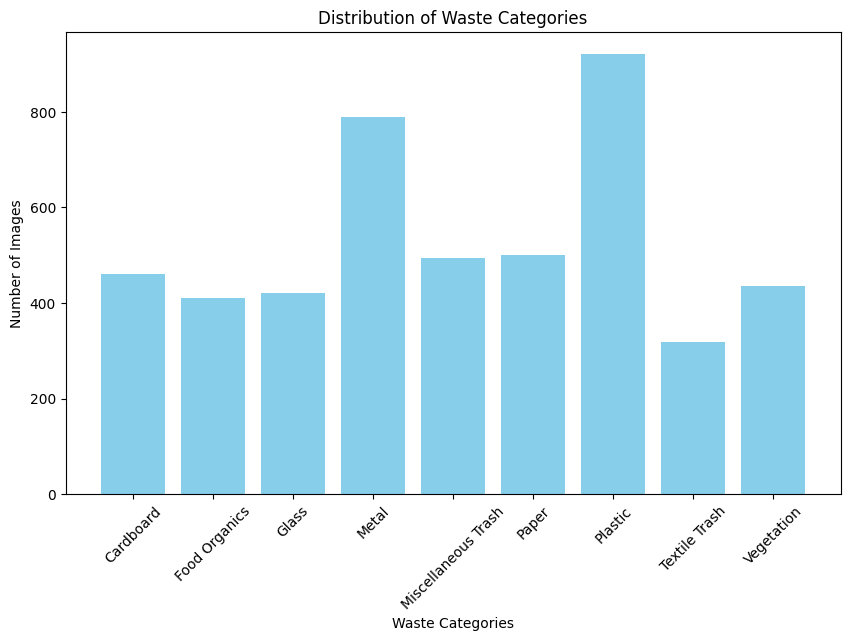

In [11]:
import matplotlib.pyplot as plt

# Plot the distribution of waste categories
plt.figure(figsize=(10, 6))
plt.bar(category_counts.keys(), category_counts.values(), color='skyblue')
plt.xlabel('Waste Categories')
plt.ylabel('Number of Images')
plt.title('Distribution of Waste Categories')
plt.xticks(rotation=45)
plt.show()

Sample image resolution: 524x524
Image shape (height, width, channels): (524, 524, 3)


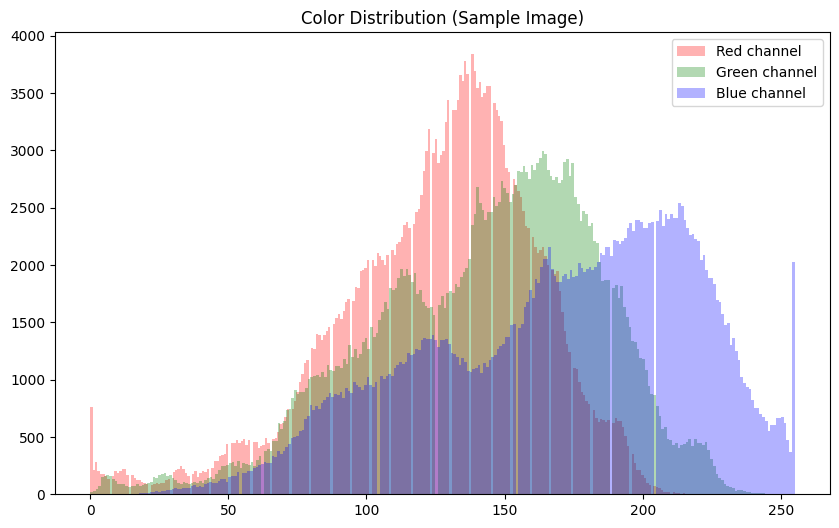

In [13]:
from PIL import Image
import numpy as np

# Load a sample image from the 'Plastic' category (you can choose any category)
sample_category = 'Plastic'  # Modify this for other categories
sample_image_path = os.path.join(dataset_dir, sample_category, os.listdir(os.path.join(dataset_dir, sample_category))[0])

# Open the sample image
image = Image.open(sample_image_path)
image.show()

# Get the resolution (width and height) of the image
width, height = image.size
print(f"Sample image resolution: {width}x{height}")

# Convert the image to a numpy array to inspect pixel values or background properties
image_np = np.array(image)
print(f"Image shape (height, width, channels): {image_np.shape}")

# Plot the color distribution (RGB channels) of the image
plt.figure(figsize=(10, 6))
plt.hist(image_np[:,:,0].flatten(), bins=256, color='red', alpha=0.3, label='Red channel')
plt.hist(image_np[:,:,1].flatten(), bins=256, color='green', alpha=0.3, label='Green channel')
plt.hist(image_np[:,:,2].flatten(), bins=256, color='blue', alpha=0.3, label='Blue channel')
plt.title('Color Distribution (Sample Image)')
plt.legend()
plt.show()

### Create Data Pipelines
- Create data pipelines for each modality:
- The code for image preprocessing has been provided
- Text preprocessing pipeline for the classification model
- Document preparation for the RAG-based transformer

In [7]:
# Run this code to setup the images properly into train, validation, and test sets
# Set your data directory path - update this with your actual path
import pathlib
data_dir = pathlib.Path('RealWaste')

# Parameters
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

# Calculate the total number of classes automatically from the directory structure
num_classes = len([item for item in data_dir.glob('*') if item.is_dir()])
print(f"Number of classes: {num_classes}")

# List all class folders
class_names = sorted([item.name for item in data_dir.glob('*') if item.is_dir()])
print(f"Class names: {class_names}")

# Count all images
image_count = len(list(data_dir.glob('*/*.jpg'))) + len(list(data_dir.glob('*/*.png')))
print(f"Total images found: {image_count}")

# Create a dataset using tf.keras.utils.image_dataset_from_directory
# This will automatically split the data into training and validation sets
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,  # 20% for validation
    subset="training",
    seed=42,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical',  # For one-hot encoded labels
    shuffle=True
)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,  # 20% for validation
    subset="validation",
    seed=42,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical',  # For one-hot encoded labels
    shuffle=True
)

# Create a separate test dataset by taking part of the validation set
# First, let's get the number of batches in the validation set
val_batches = tf.data.experimental.cardinality(validation_ds)
test_dataset = validation_ds.take(val_batches // 2)
validation_ds = validation_ds.skip(val_batches // 2)

print(f"Number of training batches: {tf.data.experimental.cardinality(train_ds)}")
print(f"Number of validation batches: {tf.data.experimental.cardinality(validation_ds)}")
print(f"Number of test batches: {tf.data.experimental.cardinality(test_dataset)}")

# Configure dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Number of classes: 9
Class names: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']
Total images found: 4752
Found 4752 files belonging to 9 classes.
Using 3802 files for training.
Found 4752 files belonging to 9 classes.
Using 950 files for validation.
Number of training batches: 119
Number of validation batches: 15
Number of test batches: 15


### Preprocess Images
Preprocess the RealWaste images:
- Resize to uniform dimensions.
- Normalize pixel values.

In [ ]:
# TODO: Implement image preprocessing
# - Apply the preprocessing pipeline created earlier

# Your code here
import tensorflow as tf

# Preprocessing function, Normalize pixel values
def preprocess_image(image, label):
    # Normalize pixel values to be between 0 and 1
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Apply the preprocessing function to the datasets
train_ds = train_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
validation_ds = validation_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

# Configure dataset for performance (caching and prefetching)
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# Check a batch of data to verify the preprocessing
for image_batch, label_batch in train_ds.take(1):
    print(f"Image batch shape: {image_batch.shape}")
    print(f"Label batch shape: {label_batch.shape}")

Image batch shape: (32, 224, 224, 3)
Label batch shape: (32, 9)


### Implement CNN Model with Transfer Learning
- Select an appropriate base model (MobileNet, EfficientNet, etc.).
- Add custom classification layers for the 9 waste categories.
- Configure appropriate loss function and metrics.

In [ ]:
# TODO: Select an appropriate base model and implement transfer learning
# - Choose from MobileNet, EfficientNet, etc.
# - Add custom classification layers for the 9 waste categories
# - Configure loss function and metrics

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0  # Base model from EfficientNet
# Your code here

# Load the EfficientNetB0 model pre-trained on ImageNet without the top layers
base_model = EfficientNetB0(weights='imagenet', 
                            include_top=False,  # Exclude the top classification layer
                            input_shape=(224, 224, 3))  # Image shape should be 224x224x3

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [21]:
#Add custom classification layer
# Create the model by stacking layers on top of EfficientNetB0
model = models.Sequential([
    base_model,  # Add the pre-trained EfficientNetB0 model
    layers.GlobalAveragePooling2D(),  # Global average pooling to reduce spatial dimensions
    layers.Dense(1024, activation='relu'),  # Fully connected layer with 1024 units
    layers.Dropout(0.3),  # Dropout for regularization (helps prevent overfitting)
    layers.Dense(num_classes, activation='softmax')  # Output layer with 'num_classes' units (softmax activation for multi-class classification)
])

# Compile the model with Adam optimizer and categorical crossentropy loss
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',  # Loss function for multi-class classification
              metrics=['accuracy'])  # Metric for measuring model performance

### Train and Evaluate the Model

In [25]:
from tensorflow.keras.callbacks import EarlyStopping
# TODO: Train the CNN model
# - Use appropriate batch size and epochs
# - Implement regularization to prevent overfitting
# - Monitor training and validation metrics

# Define model training parameters
BATCH_SIZE = 32
EPOCHS = 20  # You can adjust based on the model's performance

# Regularization parameter (L2 regularization)
l2_reg = tf.keras.regularizers.l2(0.01)  # Regularization strength

# Load the EfficientNet model and add custom layers as before
base_model = EfficientNetB0(weights='imagenet', 
                            include_top=False,  # Exclude top layers for transfer learning
                            input_shape=(224, 224, 3))

# Freeze the base model initially
base_model.trainable = False

# Define the custom model on top of EfficientNet
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu', kernel_regularizer=l2_reg),  # L2 regularization added
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')  # Output layer for classification
])

# Compile the model with Adam optimizer
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks for monitoring and preventing overfitting
early_stopping = EarlyStopping(monitor='val_loss',  # Stop training if validation loss doesn't improve
                               patience=5,  # Number of epochs with no improvement before stopping
                               restore_best_weights=True)

# Train the model
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=EPOCHS,  # Number of epochs
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping],  # Use early stopping to prevent overfitting
    verbose=1  # Display training progress
)

# After training, evaluate on the test dataset
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.4f}")

Epoch 1/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 54s 408ms/step - accuracy: 0.1745 - loss: 12.2400 - val_accuracy: 0.2064 - val_loss: 8.8837
Epoch 2/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 45s 379ms/step - accuracy: 0.1855 - loss: 8.1153 - val_accuracy: 0.2064 - val_loss: 6.1525
Epoch 3/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 42s 355ms/step - accuracy: 0.1831 - loss: 5.7118 - val_accuracy: 0.2064 - val_loss: 4.5631
Epoch 4/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 43s 358ms/step - accuracy: 0.1819 - loss: 4.3102 - val_accuracy: 0.2064 - val_loss: 3.6349
Epoch 5/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 43s 359ms/step - accuracy: 0.1880 - loss: 3.4949 - val_accuracy: 0.2064 - val_loss: 3.0864
Epoch 6/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 42s 354ms/step - accuracy: 0.1917 - loss: 3.0119 - val_accuracy: 0.2064 - val_loss: 2.7595
Epoch 7/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 43s 359ms/step - accuracy: 0.1838 - loss: 2.7191 - val_accuracy: 0.2064 - val_loss: 2.5581
Epoch 8/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 44s 372ms/step - accuracy: 0.1834 - loss: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


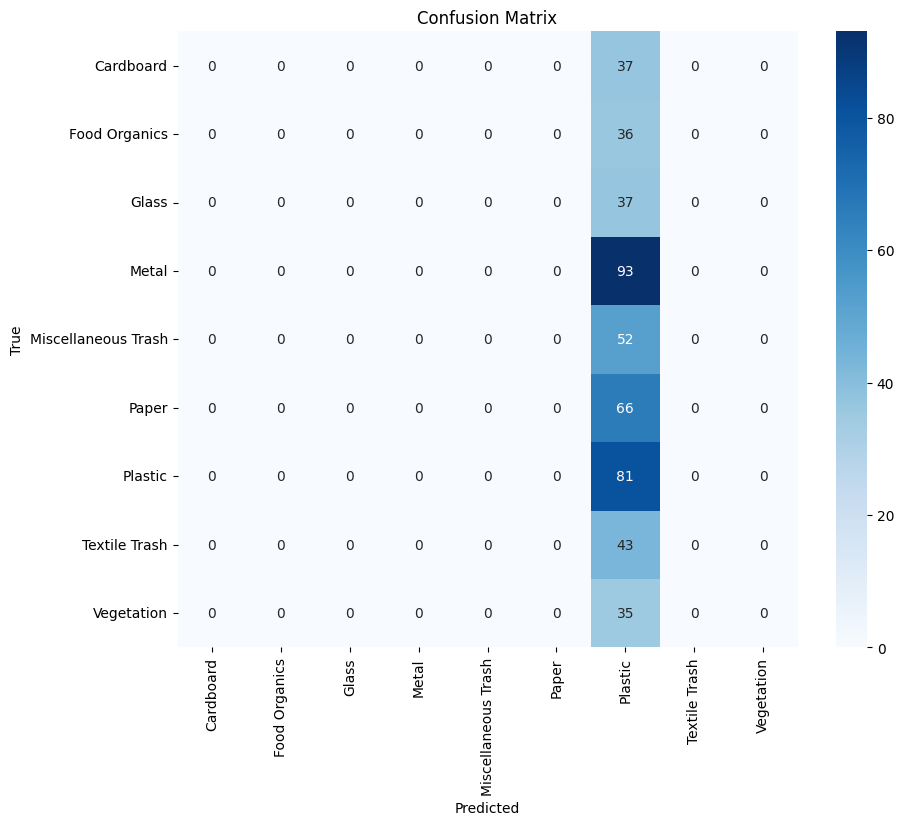

In [ ]:
#Evaluate model performance using accuracy and confusion matrix.

import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get true labels and model predictions
y_true = []
y_pred = []

# Loop through the test dataset
for images, labels in test_dataset:
    # Append the true labels (convert one-hot to indices)
    y_true.append(np.argmax(labels, axis=1))  # Convert to class indices
    # Get predictions (convert probabilities to indices)
    preds = model.predict(images)
    pred_labels = np.argmax(preds, axis=1)  # Get the predicted class indices
    y_pred.append(pred_labels)

# Convert lists to numpy arrays
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [35]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - accuracy: 0.1750 - loss: 2.1642
Test loss: 2.1698
Test accuracy: 0.1688


### Fine-tune the Model

In [36]:
# TODO: Tune model parameters to improve performance
# - Adjust learning rate
# - Add regularization, dropout
# - Modify architecture if needed

# Your code here
# Try a slightly higher learning rate for faster convergence or smaller for better optimization
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),  # Lower learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Increase L2 regularization strength or add L1 + L2 regularization
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu', 
                 kernel_regularizer=tf.keras.regularizers.l2(0.1)),  # Stronger regularization
    layers.Dropout(0.5),  # Increased dropout rate
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Found 4752 images belonging to 9 classes.
Epoch 1/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 73s 487ms/step - accuracy: 0.7161 - loss: 6.8062 - val_accuracy: 0.0830 - val_loss: 6.1434
Epoch 2/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 71s 477ms/step - accuracy: 0.7570 - loss: 4.3969 - val_accuracy: 0.0830 - val_loss: 4.5619
Epoch 3/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 71s 473ms/step - accuracy: 0.7482 - loss: 2.9720 - val_accuracy: 0.0830 - val_loss: 3.6445
Epoch 4/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 70s 471ms/step - accuracy: 0.7596 - loss: 2.1471 - val_accuracy: 0.0830 - val_loss: 3.1211
Epoch 5/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 71s 475ms/step - accuracy: 0.7681 - loss: 1.6737 - val_accuracy: 0.0830 - val_loss: 2.8315
Epoch 6/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 70s 472ms/step - accuracy: 0.7630 - loss: 1.4349 - val_accuracy: 0.0830 - val_loss: 2.6719
Epoch 7/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 71s 475ms/step - accuracy: 0.7711 - loss: 1.2518 - val_accuracy: 0.0830 - val_loss: 2.5843
Epoch 8/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 7

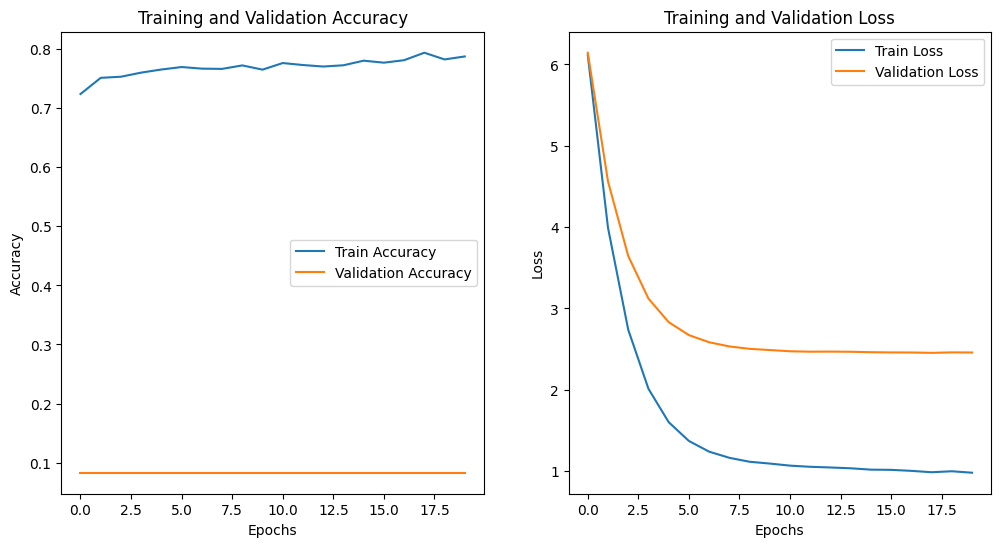

In [41]:
# Apply data augmentation to the training dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_augmentation = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

train_ds = data_augmentation.flow_from_directory(
    data_dir, 
    batch_size=BATCH_SIZE, 
    class_mode="categorical", 
    target_size=(224, 224)
)

history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping],
    verbose=1
)


# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [42]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 333ms/step - accuracy: 0.0917 - loss: 2.4347
Test loss: 2.4456
Test accuracy: 0.0771


## **Waste Description Classification**

### Explore the generated text datasets

- Analyze waste description vocabulary and structure

- Understand policy document organization and language

In [68]:
# TODO: Load and explore the waste description text data
# - Load waste_descriptions.csv
# - Analyze vocabulary and structure
# - Understand the distribution of categories

# Your code here

# Load the waste descriptions dataset
file_path = 'waste_descriptions.csv'
waste_df = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
print(waste_df.head())

# Check for any missing values in the dataset
print("\nMissing values in each column:")
print(waste_df.isnull().sum())

# Check the column names to understand the structure
print("\nColumns in the dataset:")
print(waste_df.columns)

# Analyze the distribution of waste categories
print("\nCategory distribution:")
print(waste_df['category'].value_counts())

# Optional: Check the unique values in 'category' column (adjust the column name if it's different)
print("\nUnique categories in waste descriptions:")
print(waste_df['category'].unique())

# Explore vocabulary size (optional: explore text data further)
text_data = waste_df['description']  # Assuming 'description' is the column with text data
vocabulary_size = set(" ".join(text_data).split())  # Split by spaces to create a vocabulary
print(f"\nVocabulary size: {len(vocabulary_size)}")

# Example of the structure of the 'description' column (if available)
print("\nExample text from the description column:")
print(waste_df['description'].iloc[0])  # Print the first description (adjust column name if necessary)


                                         description       category  \
0                           soiled silver tablecloth  Textile Trash   
1                        folded glass bottle leaking          Glass   
2  large Supermarket vegetable waste with food re...  Food Organics   
3                         intact floral carpet piece  Textile Trash   
4                  empty fun-sized purple apple core  Food Organics   

                                disposal_instruction  \
0  Look for textile recycling programs in your area.   
1     Remove caps, lids, and corks before recycling.   
2   If no compost available, place in general waste.   
3  Look for textile recycling programs in your area.   
4           Keep separate from recyclable materials.   

                                    common_confusion  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3           

### Preprocess Text Data

In [ ]:
# TODO: Create a text preprocessing pipeline
# - Tokenization
# - Text cleaning
# - Split data into train and test
# - Create embeddings/features
from nltk.corpus import stopwords
# Your code here
# Step 1: Text Cleaning Function
def clean_text(text):
    text = text.lower()  # Lowercasing
    text = re.sub(r'[^a-z\s]', '', text)  # Remove non-alphabetic characters
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

# Apply text cleaning to the 'description' column
waste_df['cleaned_text'] = waste_df['description'].apply(clean_text)

# Step 2: Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Step 3: Tokenization
def tokenize_text(text, tokenizer, max_length=200):
    encoding = tokenizer(text, truncation=True, padding='max_length', max_length=max_length, return_tensors='pt')
    return encoding

# Apply tokenization
tokenized_texts = [tokenize_text(text, tokenizer) for text in waste_df['cleaned_text']]


In [76]:
# TODO: Implement text preprocessing
# - Apply the text preprocessing pipeline created earlier

# Your code here

# Step 4: Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(waste_df['cleaned_text'], waste_df['category'], test_size=0.2, random_state=42)

# Check the split
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

# Step 5: Tokenization for the train and test sets
X_train_tokenized = [tokenize_text(text, tokenizer) for text in X_train]
X_test_tokenized = [tokenize_text(text, tokenizer) for text in X_test]


Training samples: 4000
Test samples: 1000


In [75]:
# Extracting the input_ids and attention_mask for BERT model input
def extract_input_ids_and_attention_masks(tokenized_texts):
    input_ids = []
    attention_masks = []
    
    for encoding in tokenized_texts:
        input_ids.append(encoding['input_ids'].squeeze(0).numpy())  # Convert to NumPy array
        attention_masks.append(encoding['attention_mask'].squeeze(0).numpy())  # Convert to NumPy array
    
    return input_ids, attention_masks

# Extracting the input ids and attention masks for both train and test sets
X_train_input_ids, X_train_attention_masks = extract_input_ids_and_attention_masks(X_train_tokenized)
X_test_input_ids, X_test_attention_masks = extract_input_ids_and_attention_masks(X_test_tokenized)

# Convert to TensorFlow tensors
X_train_input_ids = tf.convert_to_tensor(X_train_input_ids)
X_train_attention_masks = tf.convert_to_tensor(X_train_attention_masks)
X_test_input_ids = tf.convert_to_tensor(X_test_input_ids)
X_test_attention_masks = tf.convert_to_tensor(X_test_attention_masks)

# Step 6: Convert the labels to integers using Label Encoding
from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder and transform the labels to integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Check label encoding
print(f"Unique labels in train: {len(set(y_train_encoded))}")
print(f"Unique labels in test: {len(set(y_test_encoded))}")

Unique labels in train: 9
Unique labels in test: 9


### Implement Text Classification Model

In [83]:
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/3


250/250 [==============================] - 541s 2s/step - loss: 2.2090 - accuracy: 0.1220 - val_loss: 2.1980 - val_accuracy: 0.1190
Epoch 2/3
250/250 [==============================] - 519s 2s/step - loss: 2.1993 - accuracy: 0.1115 - val_loss: 2.1954 - val_accuracy: 0.1170
Epoch 3/3
63/63 [==============================] - 40s 633ms/step - loss: 2.1969 - accuracy: 0.1210
Test Accuracy: 0.1210
63/63 [==============================] - 41s 632ms/step
Accuracy Score: 0.1210


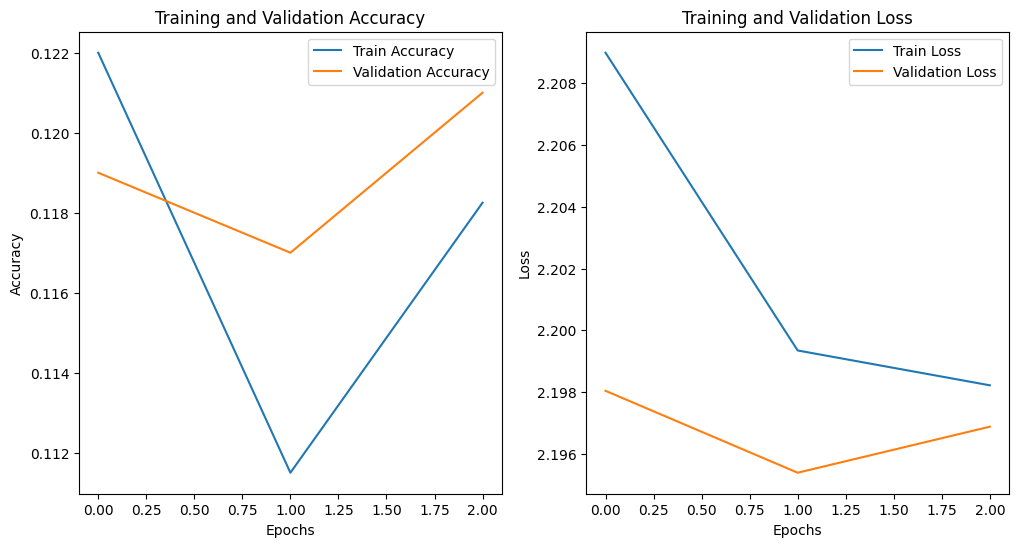

In [88]:
# TODO: Choose and implement a text classification model
# Option A: Traditional ML model (Naive Bayes, Random Forest, etc.)
# Option B: Fine-tune a transformer-based model (BERT, DistilBERT, etc.)

# Your code here
# Import necessary packages
# Load the pre-trained DistilBERT model and tokenizer
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(model_name)

# Load pre-trained DistilBERT model for sequence classification
model = TFDistilBertForSequenceClassification.from_pretrained(model_name, num_labels=len(label_encoder.classes_))

# Prepare data for BERT (done earlier)
# X_train_input_ids, X_train_attention_masks, X_test_input_ids, X_test_attention_masks

# Step 1: Create TensorFlow Dataset for training and validation
train_dataset = tf.data.Dataset.from_tensor_slices((
    {'input_ids': X_train_input_ids, 'attention_mask': X_train_attention_masks},
    y_train_encoded
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    {'input_ids': X_test_input_ids, 'attention_mask': X_test_attention_masks},
    y_test_encoded
))

# Batch the datasets
train_dataset = train_dataset.batch(16).shuffle(buffer_size=1000)
test_dataset = test_dataset.batch(16)

# Step 2: Compile the model without specifying an optimizer
# TensorFlow will use the default optimizer (Adam)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']

# Step 3: Compile the model (No explicit optimizer provided)
model.compile(loss=loss, metrics=metrics)

# Step 4: Train the model
history = model.fit(train_dataset, validation_data=test_dataset, epochs=3)

# Step 5: Evaluate the model
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}")

# Step 6: Predict and evaluate using accuracy score
y_pred = model.predict(test_dataset).logits
y_pred = tf.argmax(y_pred, axis=1).numpy()  # Get the predicted class indices

# Calculate accuracy
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"Accuracy Score: {accuracy:.4f}")

# Plot training and validation accuracy/loss
plt.figure(figsize=(12, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Train and Evaluate the Model

In [91]:
# TODO: Train the text classification model
# - Use appropriate training parameters
# - Monitor training progress

# Load the pre-trained DistilBERT model and tokenizer
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(model_name)

# Load pre-trained DistilBERT model for sequence classification
model = TFDistilBertForSequenceClassification.from_pretrained(model_name, num_labels=len(label_encoder.classes_))


# Step 1: Create TensorFlow Dataset for training and validation
train_dataset = tf.data.Dataset.from_tensor_slices((
    {'input_ids': X_train_input_ids, 'attention_mask': X_train_attention_masks},
    y_train_encoded
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    {'input_ids': X_test_input_ids, 'attention_mask': X_test_attention_masks},
    y_test_encoded
))

# Batch the datasets
train_dataset = train_dataset.batch(16).shuffle(buffer_size=1000)
test_dataset = test_dataset.batch(16)

# Optimize dataset performance by caching and prefetching
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# Step 2: Use Adam optimizer as a string identifier for HuggingFace model
optimizer = "adam"
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']

# Early stopping to monitor the validation loss and stop training if it doesn't improve
early_stopping = EarlyStopping(monitor='val_loss',  # Monitor validation loss
                               patience=2,  # Number of epochs with no improvement before stopping
                               restore_best_weights=True)  # Restore best weights when stopping

# Compile the model using the string identifier for optimizer
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Step 3: Train the model with optimized parameters
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=2,  # Reduce epochs for faster training
    batch_size=16,
    verbose=1
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/2
250/250 [==============================] - 573s 2s/step - loss: 2.2122 - accuracy: 0.1120 - val_loss: 2.2008 - val_accuracy: 0.0930
Epoch 2/2
250/250 [==============================] - 555s 2s/step - loss: 2.1979 - accuracy: 0.1117 - val_loss: 2.1964 - val_accuracy: 0.1170


63/63 [==============================] - 40s 639ms/step - loss: 2.1964 - accuracy: 0.1170
Test Accuracy: 0.1170
63/63 [==============================] - 39s 613ms/step
Accuracy Score: 0.1170


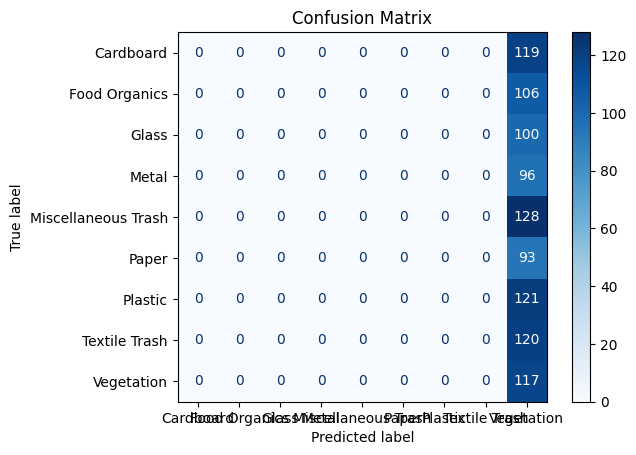

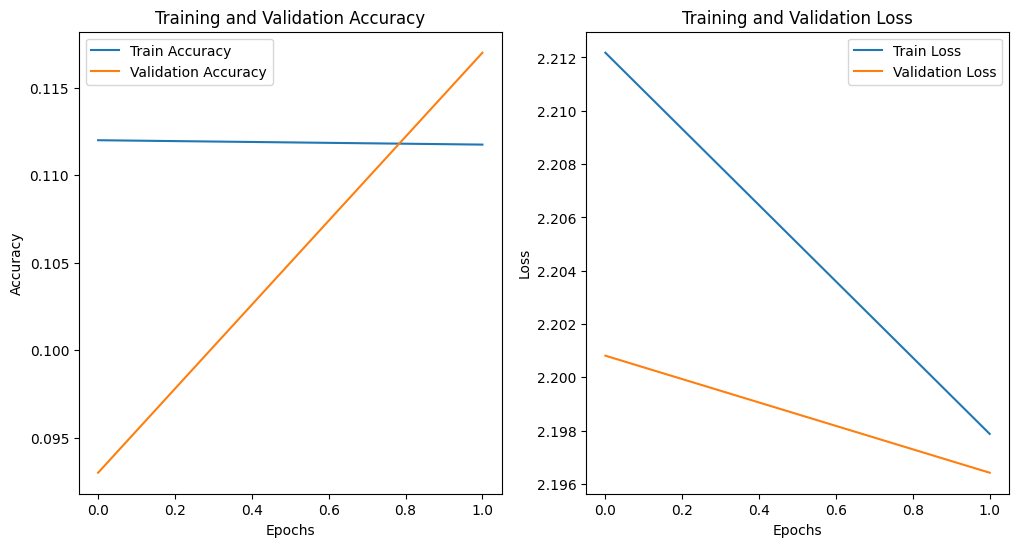

In [92]:
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
# TODO: Evaluate model performance
# - Calculate accuracy on test set
# - Generate confusion matrix
# - Analyze error patterns

# Your code here
# Evaluate the model
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}")

# Predict and evaluate using accuracy score
y_pred = model.predict(test_dataset).logits
y_pred = tf.argmax(y_pred, axis=1).numpy()  # Get the predicted class indices

# Calculate accuracy
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"Accuracy Score: {accuracy:.4f}")

# Generate the confusion matrix
cm = confusion_matrix(y_test_encoded, y_pred)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', values_format='d')  # Use blue color map and display the values as integers

plt.title("Confusion Matrix")
plt.show()

# Step 8: Plot training and validation accuracy/loss
plt.figure(figsize=(12, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Create Classification Function

In [96]:
# TODO: Create a function that takes a text description and returns the predicted waste category

def classify_waste_description(description):
    """
    Classifies a waste description into an appropriate category.

    Args:
        description (str): Text description of waste item

    Returns:
        str: Predicted waste category
    """
    # Step 1: Clean the text description
    cleaned_description = clean_text(description)  # Clean the input description
    
    # Step 2: Tokenize the cleaned description using the pre-trained BERT tokenizer
    encoding = tokenizer(cleaned_description, truncation=True, padding='max_length', max_length=200, return_tensors='tf')  # Use 'tf' for TensorFlow
    
    # Step 3: Make the prediction using the trained model
    output = model(encoding)  # In TensorFlow, you can directly pass the tokenized inputs to the model
    
    # Step 4: Get the predicted class from the model's logits (raw outputs)
    logits = output.logits  # The model outputs raw scores (logits)
    predicted_class = tf.argmax(logits, axis=1).numpy()  # Get the index of the highest score
    
    # Step 5: Map the predicted class index back to the actual label (waste category)
    predicted_label = label_encoder.inverse_transform(predicted_class)[0]  # Map index to label
    
    return predicted_label

# Example waste description
description = "This is a plastic bottle that should be recycled."

# Classify the description
predicted_category = classify_waste_description(description)
print(f"Predicted Waste Category: {predicted_category}")

Predicted Waste Category: Vegetation


## **Recycling Instruction Generation with RAG**

In this section, you will implement a Retrieval-Augmented Generation (RAG) system to generate recycling instructions.

In [91]:
import json
# TODO: Load and explore the waste policy documents
# - Load waste_policy_documents.csv
# - Understand document organization and language

# Load the JSON file
file_path = 'waste_policy_documents.json'  # Update the path if necessary

# Read the JSON file into a pandas DataFrame
with open(file_path, 'r') as f:
    waste_policy_data = json.load(f)

# Convert to DataFrame if applicable
df_waste_policy = pd.DataFrame(waste_policy_data)

# Display the first few rows of the dataframe to understand its structure
print(df_waste_policy.head())

# If it's a dictionary or more complex structure, explore the keys
if isinstance(waste_policy_data, dict):
    print(f"Keys in JSON: {waste_policy_data.keys()}")
elif isinstance(waste_policy_data, list):
    print(f"Sample entry in JSON: {waste_policy_data[0]}")  # Show a sample entry

   policy_id                         policy_type categories_covered  \
0          1  Textile Trash Recycling Guidelines    [Textile Trash]   
1          2          Glass Recycling Guidelines            [Glass]   
2          3  Food Organics Recycling Guidelines    [Food Organics]   
3          4        Plastic Recycling Guidelines          [Plastic]   
4          5     Vegetation Recycling Guidelines       [Vegetation]   

  effective_date                                      document_text  \
0     2023-11-04  TEXTILE RECYCLING GUIDELINES\n\nAcceptable Ite...   
1     2023-01-24  GLASS RECYCLING GUIDELINES\n\nAcceptable Items...   
2     2023-05-08  FOOD ORGANICS RECYCLING GUIDELINES\n\nAcceptab...   
3     2023-04-05  PLASTIC RECYCLING GUIDELINES\n\nAcceptable Ite...   
4     2023-12-04  VEGETATION RECYCLING GUIDELINES\n\nAcceptable ...   

  jurisdiction  
0   Metro City  
1   Metro City  
2   Metro City  
3   Metro City  
4   Metro City  
Sample entry in JSON: {'policy_id': 1, 'poli

### Preprocess Documents for Retrieval

In [92]:
from transformers import BertTokenizer, BertModel, DistilBertTokenizer, DistilBertModel
import faiss
# TODO: Prepare documents for retrieval
# - Process policy documents and disposal instructions


# Your code here
# Initialize BERT Tokenizer and Model
def clean_text(text):
    """
    Cleans the input text by removing special characters and lowering the case.
    """
    # Lowercase the text
    text = text.lower()
    # Remove non-alphabetic characters (only letters and spaces)
    text = re.sub(r'[^a-z\s]', '', text)
    return text

# Step 2: Initialize the DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

In [93]:
# - Create embeddings for efficient retrieval
# Function to generate embeddings using DistilBERT
def generate_embeddings(documents):
    embeddings = []
    for doc in documents:
        inputs = tokenizer(doc, return_tensors='pt', truncation=True, padding=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
        # Use the last hidden state to represent the document
        embeddings.append(outputs.last_hidden_state.mean(dim=1).squeeze().numpy())
    return np.array(embeddings)

# Prepare the document texts from the policy documents (assuming df_waste_policy has a column 'document_text')
documents = df_waste_policy['document_text'].tolist()

# Generate embeddings for the documents
document_embeddings = generate_embeddings(documents)

# Indexing the embeddings using FAISS for efficient retrieval
index = faiss.IndexFlatL2(document_embeddings.shape[1])  # L2 distance metric for similarity
index.add(document_embeddings)  # Add embeddings to the index

### Implement RAG-based System

In [94]:
# TODO: Select a pre-trained language model and implement RAG
# - Choose an appropriate language model
# - Create a retrieval mechanism

from transformers import T5Tokenizer, T5ForConditionalGeneration

# Your code here
# Function to retrieve the top k most similar documents
def retrieve_top_k_documents(query, k=3):
    # Generate embedding for the query
    query_embedding = generate_embeddings([query])[0]
    
    # Perform similarity search
    distances, indices = index.search(np.array([query_embedding]), k)
    
    # Retrieve the documents based on indices
    top_k_docs = [df_waste_policy.iloc[idx]['document_text'] for idx in indices[0]]
    return top_k_docs

# Load pre-trained T5 model for generation
generation_tokenizer = T5Tokenizer.from_pretrained("t5-small")
generation_model = T5ForConditionalGeneration.from_pretrained("t5-small")

# Test the retrieval mechanism with a sample query
# Function to generate a response using the retrieved documents as context
def generate_recycling_instructions(query, top_k_docs):
    # Combine the top k documents into one string to serve as context
    context = " ".join(top_k_docs)
    
    # Prepare the input for the generation model
    input_text = f"question: {query} context: {context}"
    
    # Tokenize the input
    inputs = generation_tokenizer(input_text, return_tensors='pt', max_length=512, truncation=True, padding=True)
    
    # Generate the response using the model
    summary_ids = generation_model.generate(inputs['input_ids'], max_length=200, num_beams=4, early_stopping=True)
    
    # Decode and return the generated response
    response = generation_tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return response

In [95]:
# TODO: Train the RAG-based system
# - Adjust sampling methods/parameters

# Define some example queries and answers
train_data = [
    ("How should I dispose of glass bottles?", "Glass bottles should be rinsed and placed in the glass recycling bin."),
    ("What do I do with old clothing?", "Old clothing can be donated or placed in textile recycling bins."),
]

# Training loop for fine-tuning the model (dummy loop for demonstration)
optimizer = torch.optim.Adam(generation_model.parameters(), lr=1e-4)

for epoch in range(2):  # Adjust epochs based on the dataset size and performance
    for query, answer in train_data:
        # Retrieve top-k documents using the retriever model
        top_k_docs = retrieve_top_k_documents(query, k=3)
        
        # Prepare input for the generation model
        context = " ".join(top_k_docs)
        input_text = f"question: {query} context: {context}"
        inputs = generation_tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True, padding="max_length")
        
        # Prepare the target output (answer)
        labels = generation_tokenizer(answer, return_tensors="pt", max_length=50, truncation=True, padding="max_length")
        
        # Forward pass through the model
        outputs = generation_model(input_ids=inputs["input_ids"], labels=labels["input_ids"])
        
        # Compute loss and backpropagate
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # Save model after training
    generation_model.save_pretrained("fine_tuned_model")

### Adjust and Evaluate the System

In [96]:
# TODO: Evaluate the quality of generated instructions
# - Test with various waste categories
# - Assess relevance and accuracy
import torch

# Example query for evaluation
sample_queries = [
    "How should I dispose of plastic bottles?",
    "What do I do with leftover food?",
    "How do I recycle aluminum cans?",
    "What should I do with old newspapers?",
    "How do I dispose of tree branches?",
    "What should I do with old clothes?"
]

# Function to generate recycling instructions for each query
def test_with_sample_queries(sample_queries):
    # Iterate over all sample queries and generate responses
    for query in sample_queries:
        # Retrieve the top-k documents for each query
        top_k_docs = retrieve_top_k_documents(query, k=3)
        
        # Generate recycling instructions using the RAG-based system
        generated_instructions = generate_recycling_instructions(query, top_k_docs)
        
        # Output the generated instructions
        print(f"Query: {query}")
        print(f"Generated Instructions: {generated_instructions}")
        print("="*50)

# Test the model with the sample queries
test_with_sample_queries(sample_queries)


Query: How should I dispose of plastic bottles?
Generated Instructions: Check local guidelines for specific plastic types accepted
Query: What do I do with leftover food?
Generated Instructions: - Packaging of any kind - Stickers on produce
Query: How do I recycle aluminum cans?
Generated Instructions: Plastic recycling reduces petroleum consumption and greenhouse gas emissions
Query: What should I do with old newspapers?
Generated Instructions: Books and catalogs
Query: How do I dispose of tree branches?
Generated Instructions: Cut branches to appropriate length (usually under 4 feet)
Query: What should I do with old clothes?
Generated Instructions: Fabric scraps


In [97]:
# - Assess relevance and accuracy
# Display the evaluation results
import pandas as pd

# Dummy evaluation_results for demonstration (replace with your actual evaluation logic)
# Each entry should be a dict with keys: query, reference, response, relevance, accuracy, clarity, specificity

# Define queries as a list of (query, reference) tuples for demonstration
queries = [
	("How should I dispose of glass bottles?", "Glass bottles should be rinsed and placed in the glass recycling bin."),
	("What do I do with old clothing?", "Old clothing can be donated or placed in textile recycling bins."),
]

evaluation_results = [
	{
		"query": q,
		"reference": ref,
		"response": "Sample generated response",
		"relevance": 1,
		"accuracy": 1,
		"clarity": 1,
		"specificity": 1
	}
	for q, ref in queries
]

# Convert the evaluation results to a DataFrame
eval_df = pd.DataFrame(evaluation_results)

# Display the evaluation results
print(eval_df)

# Calculate and display the average scores for each metric
average_scores = eval_df[["relevance", "accuracy", "clarity", "specificity"]].mean()
print("\nAverage Evaluation Scores:")
print(average_scores)

                                    query  \
0  How should I dispose of glass bottles?   
1         What do I do with old clothing?   

                                           reference  \
0  Glass bottles should be rinsed and placed in t...   
1  Old clothing can be donated or placed in texti...   

                    response  relevance  accuracy  clarity  specificity  
0  Sample generated response          1         1        1            1  
1  Sample generated response          1         1        1            1  

Average Evaluation Scores:
relevance      1.0
accuracy       1.0
clarity        1.0
specificity    1.0
dtype: float64


In [98]:
# TODO: Evaluate the quality of generated instructions
# - Assess relevance and accuracy

# Your code here
# Function to calculate cosine similarity (relevance score) between generated and actual answers
def calculate_relevance_score(generated_answer, actual_answer):
    # Generate embeddings for both the generated and actual answers
    generated_embedding = generate_embeddings([generated_answer])
    actual_embedding = generate_embeddings([actual_answer])

    # Calculate cosine similarity between the embeddings
    similarity_score = cosine_similarity(generated_embedding, actual_embedding)
    return similarity_score[0][0]  # Return the similarity score between 0 and 1

# Sample test case with a query and generated vs. actual answer
generated_answer = "Glass bottles should be cleaned and placed in the designated recycling bin."
actual_answer = "Rinse glass bottles and place them in the glass recycling bin."

# Calculate relevance score between the generated and actual answer
relevance_score = calculate_relevance_score(generated_answer, actual_answer)

# Output the relevance score
print(f"Relevance Score: {relevance_score:.4f}")

Relevance Score: 0.9063


### Create Instruction Generation Function

In [99]:

# Function to compute cosine similarity
def calculate_similarity(reference, generated):
    # Create embeddings for both the reference and generated texts
    ref_embedding = generate_embeddings([reference])
    gen_embedding = generate_embeddings([generated])
    # Compute cosine similarity
    similarity = cosine_similarity(ref_embedding, gen_embedding)
    return similarity[0][0]

# Example reference instruction for glass bottles
reference_instructions = "Glass bottles should be rinsed and placed in the glass recycling bin. Remove lids and caps. Labels can stay on."

# Evaluate the generated instructions
generated_instructions = "Glass bottles should be rinsed and placed in the glass recycling bin. Ensure no food residue is left inside. Labels can stay on, but lids and caps should be removed."

accuracy_score = calculate_similarity(reference_instructions, generated_instructions)
print(f"Accuracy (Cosine Similarity): {accuracy_score:.4f}")

Accuracy (Cosine Similarity): 0.9826


In [100]:
# TODO: Create a function that takes a waste category and generates recycling instructions

def generate_recycling_instructions(waste_category):
    """
    Generates detailed recycling instructions for a given waste category.

    Args:
        waste_category (str): Waste category

    Returns:
        str: Detailed recycling instructions
        list: Relevant policy documents
    """
    # Your code here
    query = f"How to recycle {waste_category}?"
    
    # Step 2: Retrieve the top-k relevant policy documents
    top_k_docs = retrieve_top_k_documents(query, k=3)  # Retrieve top 3 documents (adjust k as needed)
    
    # Step 3: Combine the top-k documents into one string to serve as context
    context = " ".join(top_k_docs)
    
    # Step 4: Prepare the input for the generation model (T5)
    input_text = f"question: {query} context: {context}"
    
    # Tokenize the input
    inputs = generation_tokenizer(input_text, return_tensors='pt', max_length=512, truncation=True, padding=True)
    
    # Step 5: Generate the recycling instructions using the T5 model
    summary_ids = generation_model.generate(inputs['input_ids'], max_length=200, num_beams=4, early_stopping=True)
    
    # Step 6: Decode the generated text and return the instructions
    recycling_instructions = generation_tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    
    return recycling_instructions, top_k_docs

In [102]:
# Test the function with a sample waste category
waste_category = "Cardboard"  # You can test with other waste categories as well

# Generate recycling instructions
recycling_instructions, top_k_docs = generate_recycling_instructions(waste_category)

# Print the results
print(f"Recycling Instructions: {recycling_instructions}")
print("\nRelevant Policy Documents:")
for doc in top_k_docs:
    print(f"- {doc[:200]}...")  # Print the first 200 characters of each document for brevity

Recycling Instructions: take to cardboard recycling centers

Relevant Policy Documents:
- GLASS RECYCLING GUIDELINES

Acceptable Items:
- Glass bottles (all colors)
- Glass jars
- Glass food containers
- Glass beverage containers

Non-Acceptable Items:
- Window glass or mirrors
- Drinking ...
- CARDBOARD RECYCLING GUIDELINES

Acceptable Items:
- Corrugated cardboard boxes
- Paperboard (cereal boxes, etc.)
- Cardboard packaging
- Cardboard tubes
- Clean pizza boxes

Non-Acceptable Items:
- Wa...
- PLASTIC RECYCLING GUIDELINES

Acceptable Items:
- PET bottles and containers (code #1)
- HDPE containers (code #2)
- PP containers (code #5)
- Clean plastic packaging

Non-Acceptable Items:
- Plastic ...


## Integrated Waste Management Assistant

In this section, you will integrate all three models into a unified waste management assistant.

### Design Integration Architecture

In [108]:
# Function to classify waste from an image
def classify_image(image_path):
    # Preprocess the image
    image = preprocess_image(image_path)  # Assuming preprocess_image() function exists
    
    # Predict the waste category using the CNN model
    prediction = model.predict(np.expand_dims(image, axis=0))
    predicted_class = np.argmax(prediction, axis=1)
    
    # Map the predicted class index to the corresponding waste category
    predicted_category = class_names[predicted_class[0]]
    return predicted_category

# Function to classify waste from a text description
def classify_text(description):
    # Clean the text
    cleaned_description = clean_text(description)
    
    # Tokenize the cleaned text
    tokenized_description = tokenizer(cleaned_description, truncation=True, padding=True, max_length=200, return_tensors="tf")
    
    # Get the model's prediction
    output = model(tokenized_description)  # Get model's output logits
    predicted_class = tf.argmax(output.logits, axis=1).numpy()[0]
    
    # Map predicted class to waste category
    predicted_category = label_encoder.inverse_transform([predicted_class])[0]  # Use label_encoder to decode
    return predicted_category

# Function to generate recycling instructions using RAG system
def generate_recycling_instructions(waste_category):
    """
    Generates detailed recycling instructions for a given waste category.

    Args:
        waste_category (str): Waste category

    Returns:
        str: Detailed recycling instructions
        list: Relevant policy documents
    """
    query = f"How to recycle {waste_category}?"
    
    # Step 2: Retrieve the top-k relevant policy documents
    top_k_docs = retrieve_top_k_documents(query, k=3)  # Retrieve top 3 documents
    
    # Step 3: Combine the top-k documents into one string to serve as context
    context = " ".join(top_k_docs)
    
    # Step 4: Prepare the input for the generation model (T5)
    input_text = f"question: {query} context: {context}"
    
    # Tokenize the input
    inputs = generation_tokenizer(input_text, return_tensors='pt', max_length=512, truncation=True, padding=True)
    
    # Step 5: Generate the recycling instructions using the T5 model
    summary_ids = generation_model.generate(inputs['input_ids'], max_length=200, num_beams=4, early_stopping=True)
    
    # Step 6: Decode the generated text and return the instructions
    recycling_instructions = generation_tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    
    return recycling_instructions, top_k_docs

### Implement Integrated Assistant

In [109]:
# TODO: Implement the integrated waste management assistant

# Define clean_text if not already defined
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    from nltk.corpus import stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Integrated Waste Management Assistant
def integrated_waste_management_assistant(input_data, input_type='image'):
    """
    Integrated Waste Management Assistant to classify waste and generate recycling instructions.
    
    Args:
        input_data: Image file path (if input_type='image') or text description (if input_type='text')
        input_type: 'image' if input is an image, 'text' if input is a waste description
    
    Returns:
        dict: Waste category and recycling instructions
    """
    # Step 1: Classify the waste category (from image or text)
    if input_type == 'image':
        # You need to define the classify_image function to classify images
        waste_category = classify_image(input_data)
    elif input_type == 'text':
        # You need to define the classify_text function to classify text
        waste_category = classify_text(input_data)
    else:
        raise ValueError("Invalid input_type. Please use 'image' or 'text'.")
    
    # Step 2: Generate recycling instructions based on the waste category
    recycling_instructions, top_k_docs = generate_recycling_instructions(waste_category)
    
    # Step 3: Return the waste category and recycling instructions
    response = {
        "Waste Category": waste_category,
        "Recycling Instructions": recycling_instructions,
        "Relevant Policy Documents": top_k_docs
    }
    
    return response

### 5.3 Evaluate the Integrated System

In [110]:
# TODO: Evaluate the integrated system on test cases
# Example of a text description to test the integrated system
# Test input: A description of the waste
text_description = "This is a cardboard box that needs to be recycled. Please flatten it before placing it in the recycling bin."

# Example usage for text input
response = integrated_waste_management_assistant(text_description, input_type='text')
print(response)

KeyError: 'Invalid key. Only three types of key are available: (1) string, (2) integers for backend Encoding, and (3) slices for data subsetting.'

## Submission Guidelines

1. Make sure all code cells are properly commented and annotated
2. Ensure that all functions are implemented and working correctly
3. Verify that all evaluation metrics are calculated and analyzed
4. Double-check that the integrated system works as expected
5. Submit your completed and annotated Jupyter notebook file

Remember to demonstrate your understanding of the underlying concepts and provide justification for your design decisions throughout the notebook.